# Group assignment

In this group assignment, and with some guidance, you will work with the `energy.csv` dataset, and the goal is:
* Find new features that you can create from the existing data that improve the performance of the model
* Create a new model that uses the new features in order to predict the target: `spot_price`
* Use cross-validation and grid search to find the best combination of hyperparameters for the new model

You will be graded on the following topics (10 points):
* The quality of the new features (Up to 5 points):
    * 0.25 points per new feature *if the correlation in absolute value of that new feature with the target* is above the absolute value of correlation of the existing features
    * For example, if the correlation of the new feature with the target is -0.5, and the correlation of the existing features with the target is -0.4, then the new feature will get 0.25 points
* The performance of the new model (2 - 4 points):
    * The group with the best performance will get 4 points, and from there the rest of the groups will get points proportionally to their performance until the group with the worst performance that will get 2 point.
* Extra point for visualization and meaningful insights (1 point)

## General pipeline

Consider this a general guide for using Machine Learning to build predictions or recommendations. For every use case there will be parts that might differ, but you can follow this as an initial approach.

Steps:

0. Understanding the problem, the requirements and the goal
1. Data collection
2. Data cleaning
3. Feature engineering
4. Model training
5. Model evaluation

After evaluating our model, there are more steps like visualization, storytelling, reporting, model deployment, model monitoring, etc. These are not covered in this session.


## 0. Understanding the problem, the requirements and the goal

Our problem is that the price of electricity in the wholesale market is subject to a high volatility, therefore by having solid predictions of it, we can control our risk and hedge against it.

The requirements are that we need to provide a prediction as a 24h prediction of this price for every day in a timely manner and with some degree of accuracy.

Our goal, obviously is to obtain a model that can predict the price of electricity in the wholesale market.

In this case, since we have timeseries, we can't use the usual train-test split, so you will use the last 10 days for testing and the rest for training.

## 1. Data collection: reading the data and understanding the goal

In real life, the data is not in a CSV file, but it's rather in a database, in a directory in a bunch of files, in a streaming pipeline, etc. In this session we will use a CSV file as an example.

The data we're going to use is the `energy` dataset that we've used in the past, and our goal is to create a Machine Learning model that predicts the spot price of electricity in Spain given some power market variables.

With this approach, we will train an algorithm to learn the relationship between the variables (x) and the target variable (`spot_price`, y).

In [ ]:
# read the data
# NOTE: Update depending on where the CSV file is

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
data=pd.read_csv('/content/drive/Shared drives/Team 2.0/Python II/energy.csv')
data

,datetime,power_demand,nuclear,gas,solar,hydro,coal,wind,spot_price,year,month,day,hour,weekday
0,2018-12-31 23:00:00+00:00,23251.2,6059.2,2954.0,7.1,3202.8,1867.0,3830.3,66.88,2018,12,31,23,0
1,2019-01-01 00:00:00+00:00,22485.0,6059.2,3044.1,8.0,2884.4,1618.0,3172.1,66.88,2019,1,1,0,1
2,2019-01-01 01:00:00+00:00,20977.0,6059.2,3138.6,7.5,1950.8,1535.3,2980.5,66.00,2019,1,1,1,1
3,2019-01-01 02:00:00+00:00,19754.2,6059.2,3596.2,7.5,1675.7,1344.0,2840.0,63.64,2019,1,1,2,1
4,2019-01-01 03:00:00+00:00,19320.6,6063.4,3192.6,7.5,1581.8,1345.0,3253.4,58.85,2019,1,1,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8732,2019-12-30 19:00:00+00:00,31160.6,7106.3,4400.0,0.1,7910.8,685.0,2013.5,47.50,2019,12,30,19,0
8733,2019-12-30 20:00:00+00:00,31152.9,7106.3,4832.3,NaN,7517.6,681.0,2096.7,46.42,2019,12,30,20,0
8734,2019-12-30 21:00:00+00:00,29151.0,7105.3,4467.0,NaN,7080.2,698.0,2028.3,42.76,2019,12,30,21,0
8735,2019-12-30 22:00:00+00:00,26989.6,7107.2,4672.2,NaN,6716.1,626.0,2031.8,40.88,2019,12,30,22,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8737 entries, 0 to 8736
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   datetime      8737 non-null   object 
 1   power_demand  8737 non-null   float64
 2   nuclear       8737 non-null   float64
 3   gas           8737 non-null   float64
 4   solar         6345 non-null   float64
 5   hydro         8737 non-null   float64
 6   coal          8588 non-null   float64
 7   wind          8737 non-null   float64
 8   spot_price    8737 non-null   float64
 9   year          8737 non-null   int64  
 10  month         8737 non-null   int64  
 11  day           8737 non-null   int64  
 12  hour          8737 non-null   int64  
 13  weekday       8737 non-null   int64  
dtypes: float64(8), int64(5), object(1)
memory usage: 955.7+ KB


In [ ]:
data.describe()

,power_demand,nuclear,gas,solar,hydro,coal,wind,spot_price,year,month,day,hour,weekday
count,8737.000000,8737.000000,8737.000000,6345.000000,8737.000000,8588.000000,8737.000000,8737.000000,8737.000000,8737.000000,8737.000000,8737.000000,8737.000000
mean,28512.653474,6381.835069,5924.323967,1399.224240,2803.288108,1263.865137,6072.172588,47.705993,2018.999886,6.511617,15.680325,11.501316,2.999657
std,4566.831233,825.163584,3180.671191,1334.539134,1609.319482,1312.005015,3497.963836,10.882271,0.010698,3.441110,8.773269,6.923280,2.000258
min,16969.100000,3948.400000,388.900000,0.100000,443.300000,50.000000,353.000000,0.030000,2018.000000,1.000000,1.000000,0.000000,0.000000
25%,24662.600000,5963.100000,3255.800000,13.200000,1602.000000,515.000000,3363.600000,42.010000,2019.000000,4.000000,8.000000,6.000000,1.000000
50%,28763.700000,6908.000000,5739.400000,1160.800000,2401.700000,765.000000,5300.900000,48.990000,2019.000000,7.000000,16.000000,12.000000,3.000000
75%,31980.800000,7015.600000,8400.100000,2636.700000,3605.700000,1262.375000,8178.500000,54.540000,2019.000000,10.000000,23.000000,18.000000,5.000000
max,40094.800000,7129.100000,15082.300000,4213.100000,8346.600000,6327.900000,17768.700000,74.740000,2019.000000,12.000000,31.000000,23.000000,6.000000


In [ ]:
data.shape

(8737, 14)

Now that we have our data as a DataFrame, we can use all the data analysis techniques we know to understand the problem.

## 2. Data cleaning: preparing the data and analyze it.

Things to keep in mind when working in Machine Learning:

* Do we have categorical features? Should we encode them?
* The dates should be in a format that can be parsed by pandas, but not passed to our algorithm
* We need a strategy for NaN/missing values

### 2.1. Deal with the data

* Use the proper type for dates
* Check the distributions of the columns to see if there is some transformation that can be useful
* Check for missing values and deal with them
* Check for categorical variables and deal with them


In [ ]:
# deal with the data

#Check for missing values and deal with them
data.isnull().sum()

,0
datetime,0
power_demand,0
nuclear,0
gas,0
solar,2392
hydro,0
coal,149
wind,0
spot_price,0
year,0


In [ ]:
blackout=data[data['solar'].isnull()]['hour']
blackout.value_counts().sort_index()

,count
hour,
0,295
1,305
2,304
3,287
4,158
5,16
18,17
19,65
20,159


In [ ]:
shutdown=data[data['coal'].isnull()]['hour']
shutdown.value_counts().sort_index()

,count
hour,
0,8
1,8
2,6
3,6
4,6
5,6
6,6
7,6
8,6


In [ ]:
data['solar'].fillna(0,inplace=True)
data['coal']=data['coal'].ffill()

In [ ]:
print (data['solar'].isnull().sum())
print (data['coal'].isnull().sum())

0
0


In [ ]:
#Check the distributions of the columns to see if there is some transformation that can be useful

# Categorical features
data_transformed= data.copy()

# Select only the categorical columns > type
categorical_columns = data_transformed.select_dtypes(include=['object','category']).columns
print(categorical_columns.array) #only datetime is categorical

# Encode categorical features
# Use the proper type for dates: Parse Dates > not passed to our algorithm
data_transformed['datetime'] = pd.to_datetime(data_transformed['datetime'])

print(data_transformed)


<NumpyExtensionArray>
['datetime']
Length: 1, dtype: object
                      datetime  power_demand  nuclear     gas  solar   hydro  \
0    2018-12-31 23:00:00+00:00       23251.2   6059.2  2954.0    7.1  3202.8   
1    2019-01-01 00:00:00+00:00       22485.0   6059.2  3044.1    8.0  2884.4   
2    2019-01-01 01:00:00+00:00       20977.0   6059.2  3138.6    7.5  1950.8   
3    2019-01-01 02:00:00+00:00       19754.2   6059.2  3596.2    7.5  1675.7   
4    2019-01-01 03:00:00+00:00       19320.6   6063.4  3192.6    7.5  1581.8   
...                        ...           ...      ...     ...    ...     ...   
8732 2019-12-30 19:00:00+00:00       31160.6   7106.3  4400.0    0.1  7910.8   
8733 2019-12-30 20:00:00+00:00       31152.9   7106.3  4832.3    0.0  7517.6   
8734 2019-12-30 21:00:00+00:00       29151.0   7105.3  4467.0    0.0  7080.2   
8735 2019-12-30 22:00:00+00:00       26989.6   7107.2  4672.2    0.0  6716.1   
8736 2019-12-30 23:00:00+00:00       24350.5   7099.0  3765.

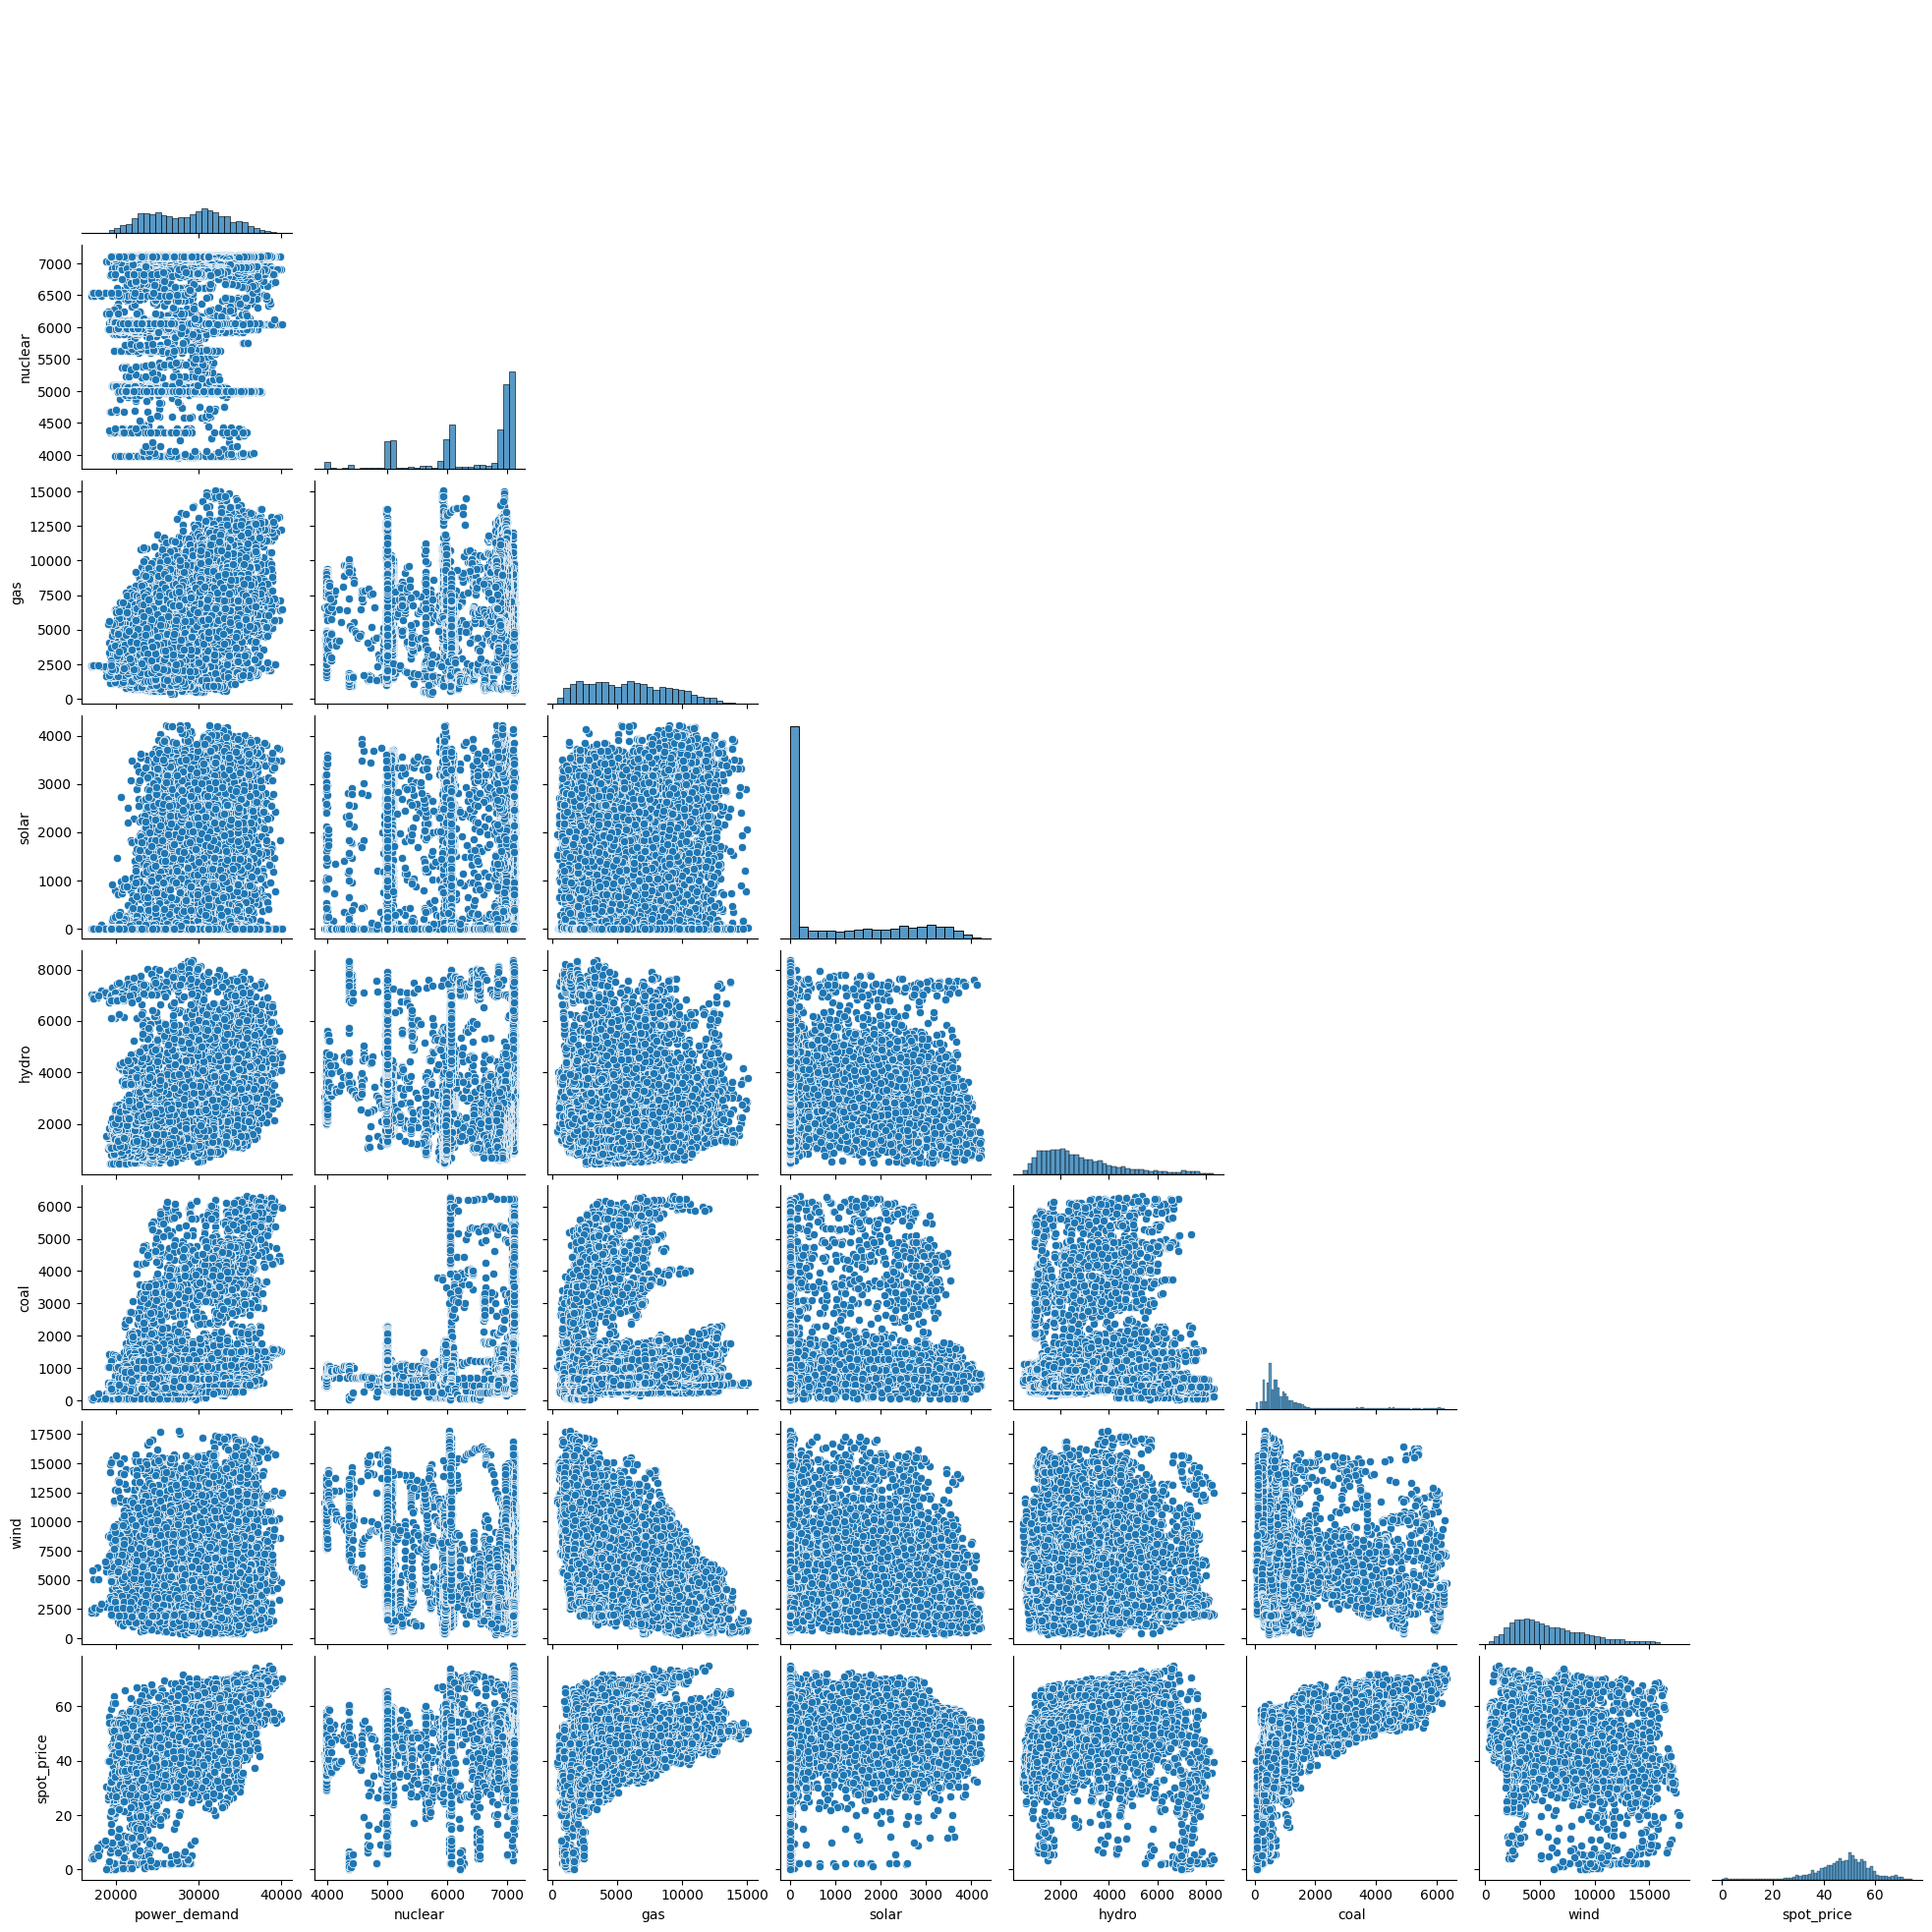

In [ ]:
import seaborn as sns

# creating a pair_plot to analyze distribution of features + correlation amongst them
cols_to_plot = ["power_demand",	"nuclear", "gas", "solar", "hydro",	"coal",	"wind",	"spot_price"]

sns.pairplot(data_transformed[cols_to_plot], corner=True)

In [ ]:
# distribution of target variable
import plotly.express as px
fig = px.histogram(data_transformed,

                    x = 'spot_price',


                    )

fig.show()

## 3. Feature engineering: creating new features and cleaning the data

In this stage, we will create new information based in what we've found in the data analysis and cleaning. It's crucial in this stage to also include the domain knowledge we have. If we don't have that knowledge, ask your colleagues, ask your boss, ask your friends, or read. It's the domain knowledge that we need to make our model work well.

### 3.1. Dealing with nuclear feature:

I hope you analized this feature. You might have seen that the distribution looks strange compared to the other features.

Hint: in Spain, the nuclear reactors average 1000 MW of power. By knowing this, you can know how many reactors are working at a given time, and the maximum and minimum number of reactors that are producing at a given time

In [ ]:
# plotting the variable

fig = px.histogram(data_transformed,

                    x = 'nuclear',


                    )

fig.show()

In [ ]:
# nuclear stuff

# possible features
# active_reactors
data_transformed['active_reactors']=data_transformed['nuclear']/1000
# max_active_reactors
data_transformed['max_active_reactors']=data_transformed['nuclear'].max()/1000
# min_active_reactors
data_transformed['min_active_reactors']=data_transformed['nuclear'].min()/1000

### 3.2. Creating new features using domain knowledge

Sometimes, you can only create new features by knowing the domain. In this case, we will create a new feature that represents the difference amount of power that is needed to be produced by the thermal power plants to cover the demand, given that the "renewable" power plants are producing at their maximum capacity in that moment.

In [ ]:
# a new feature with love from me to you

data_transformed["thermal_gap"] = (
    data_transformed["power_demand"] -
    data_transformed["nuclear"] -
    data_transformed["wind"] -
    data_transformed["solar"]
)

### 3.3 New features

Now it's your turn to create new features. You can use the ones I've created as inspiration, but you need to create at least 20 new features.

* Try ratios between features, like `solar / wind` or coverage of demand, etc
* Try more lags and rolling windows of the ratios
* Extract more information from the dates, like the day of the week, the month, the year, etc, since you won't be able to use the dates directly
* See if you can find other information outside of the dataset that can be useful, like weather data, holidays, etc
* Smooth your series

Don't be shy and create as many features as you can, and then we'll see which ones are useful.

In [ ]:
#create new variables
#data_transformed['spot_price_lag_1hr'] = data_transformed['spot_price'].shift(1)
data_transformed['spot_price_ema_24h'] = data_transformed['spot_price'].ewm(span=24).mean()
data_transformed['spot_price_rolling_mean_12h'] = data_transformed['spot_price'].rolling(window=12).mean()
data_transformed['max_spot_price_24h'] = data_transformed['spot_price'].rolling(window=24).max()
data_transformed['spot_price_lag_24hr'] = data_transformed['spot_price'].shift(24)
data_transformed['min_spot_price_24h'] = data_transformed['spot_price'].rolling(window=24).min()
data_transformed['wind_to_coal']=np.log1p(data_transformed['wind'])/np.log1p(data_transformed['coal'])
data_transformed['renewable_gap'] = data_transformed['power_demand'] - data_transformed['wind'] - data_transformed['solar']-data_transformed['hydro']
data_transformed['coal_demand'] = np.log1p(data_transformed['coal'])*np.log1p(data_transformed['power_demand'])
data_transformed['fossil_gap'] = data_transformed['power_demand'] - data_transformed['wind'] - data_transformed['solar']
data_transformed["thermal_gap"] = ( data_transformed["power_demand"] -data_transformed["nuclear"] -data_transformed["wind"] - data_transformed["solar"])
data_transformed['log_coal']=np.log1p(data_transformed['coal'])
data_transformed['nuclear_coal_log']=np.log1p(data_transformed['nuclear'])*np.log1p(data_transformed['coal'])
data_transformed['demand_supply']=data_transformed['power_demand']-(data_transformed['nuclear']+data_transformed['solar']+data_transformed['coal']+data_transformed['wind']+data_transformed['gas']+data_transformed['hydro'])
data_transformed['sqrt_coal'] = np.sqrt(data_transformed['coal'])
data_transformed['renewable_gap_lag_1hr'] = data_transformed['renewable_gap'].shift(1)
data_transformed['fossil_gap_lag_1hr'] = data_transformed['fossil_gap'].shift(1)
data_transformed['thermal_gap_coal'] = data_transformed['thermal_gap'] * data_transformed['coal']
data_transformed['fossil_gap_nuclear'] = data_transformed['fossil_gap'] * data_transformed['nuclear']
data_transformed['renewable_gap_log_coal'] = data_transformed['renewable_gap'] * np.log1p(data_transformed['coal'])
data_transformed['thermal_to_fossil_gap'] = data_transformed['thermal_gap'] / data_transformed['fossil_gap']

# Save all the names of your new features under a list called new_features
new_features = [
    'wind_to_coal', 'log_coal', 'thermal_gap', 'fossil_gap', 'renewable_gap', 'demand_supply',
    #'spot_price_lag_1hr',
    'spot_price_lag_24hr', 'max_spot_price_24h', 'min_spot_price_24h',
    'coal_demand', 'nuclear_coal_log','spot_price_rolling_mean_12h', 'spot_price_ema_24h',
    'sqrt_coal','renewable_gap_lag_1hr', 'fossil_gap_lag_1hr',
    'thermal_gap_coal','fossil_gap_nuclear', 'renewable_gap_log_coal', 'thermal_to_fossil_gap'
]

### 3.4 Feature assessment

Create a function that receives your dataframe, and the list of new features, and returns a numeric value that represents how many of the new features have a correlation with the target that is higher than the best correlation of the existing features with the target.

For example:

```python
existing_features = ['wind', 'solar', 'hydro']
new_features = ['new_feat_1', 'new_feat_2', 'new_feat_3']
```

Correlation table:

| feature    | correlation with target|
|------------|-------------|
| wind       | 0.5         |
| solar      | -0.4         |
| hydro      | 0.3         |
| new_feat_1 | 0.6         |
| new_feat_2 | 0.2         |
| new_feat_3 | -0.7         |

The function should return 2, because `new_feat_1` has a correlation of 0.6, which is higher than the highest positive correlation of the existing features with the target, and `new_feat_3` has a correlation of -0.7, which is higher than the highest negative correlation of the existing features with the target.

In [ ]:
existing_featues = ['wind', 'solar', 'hydro','coal','nuclear','gas','year','month','day','hour','weekday']

correlation_table = data_transformed[existing_featues + ['spot_price']].corr().abs()
correlation_table['spot_price'].drop('spot_price').nlargest(5)


,spot_price
coal,0.588130
month,0.526890
gas,0.359471
wind,0.354866
hour,0.207413


In [ ]:
threshold=correlation_table['spot_price'].drop('spot_price').nlargest(5).iloc[0]

correlation_table = data_transformed[new_features + ['spot_price']].corr().abs()
correlation_table['spot_price'].drop('spot_price').nlargest(20).loc[lambda x: x > threshold]

#TODO: Review the features with too high of a correlation



,spot_price
spot_price_ema_24h,0.851535
spot_price_rolling_mean_12h,0.844528
renewable_gap_log_coal,0.804605
max_spot_price_24h,0.756266
spot_price_lag_24hr,0.753316
min_spot_price_24h,0.746069
wind_to_coal,0.742390
renewable_gap,0.714612
coal_demand,0.713182
fossil_gap,0.705355


In [ ]:
#check if the function is good enough
def features_corelations(data, existing_features, new_features, target):
    existing_correlations = data[existing_features].corrwith(data[target]).abs()
    high_positive = existing_correlations.max()
    count = 0

    for feature in new_features:
        new_corr = np.abs(data[feature].corr(data[target]))
        if new_corr > high_positive:
            count += 1
            print(feature)
    return count

result = features_corelations(data_transformed, existing_featues, new_features, 'spot_price')
print(f'Number of features with correlation higher than the max of the original features: {result}')

wind_to_coal
log_coal
thermal_gap
fossil_gap
renewable_gap
demand_supply
spot_price_lag_24hr
max_spot_price_24h
min_spot_price_24h
coal_demand
nuclear_coal_log
spot_price_rolling_mean_12h
spot_price_ema_24h
sqrt_coal
renewable_gap_lag_1hr
fossil_gap_lag_1hr
thermal_gap_coal
fossil_gap_nuclear
renewable_gap_log_coal
thermal_to_fossil_gap
Number of features with correlation higher than the max of the original features: 20


In [ ]:
pd.set_option('display.max_columns', None)
data_transformed

,datetime,power_demand,nuclear,gas,solar,hydro,coal,wind,spot_price,year,month,day,hour,weekday,active_reactors,max_active_reactors,min_active_reactors,thermal_gap,spot_price_ema_24h,spot_price_rolling_mean_12h,max_spot_price_24h,spot_price_lag_24hr,min_spot_price_24h,wind_to_coal,renewable_gap,coal_demand,fossil_gap,log_coal,nuclear_coal_log,demand_supply,sqrt_coal,renewable_gap_lag_1hr,fossil_gap_lag_1hr,thermal_gap_coal,fossil_gap_nuclear,renewable_gap_log_coal,thermal_to_fossil_gap
0,2018-12-31 23:00:00+00:00,23251.2,6059.2,2954.0,7.1,3202.8,1867.0,3830.3,66.88,2018,12,31,23,0,6.0592,7.1291,3.9484,13354.6,66.880000,NaN,NaN,NaN,NaN,1.095363,16211.0,75.734166,19413.8,7.532624,65.605371,5330.8,43.208795,NaN,NaN,24933038.20,1.176321e+08,122111.361484,0.687892
1,2019-01-01 00:00:00+00:00,22485.0,6059.2,3044.1,8.0,2884.4,1618.0,3172.1,66.88,2019,1,1,0,1,6.0592,7.1291,3.9484,13245.7,66.880000,NaN,NaN,NaN,NaN,1.091061,16420.5,74.048221,19304.9,7.389564,64.359393,5699.2,40.224371,16211.0,19413.8,21431542.60,1.169723e+08,121340.334901,0.686132
2,2019-01-01 01:00:00+00:00,20977.0,6059.2,3138.6,7.5,1950.8,1535.3,2980.5,66.00,2019,1,1,1,1,6.0592,7.1291,3.9484,11929.8,66.561897,NaN,NaN,NaN,NaN,1.090369,16038.2,73.013487,17989.0,7.337132,63.902739,5305.1,39.182904,16420.5,19304.9,18315821.94,1.089989e+08,117674.393764,0.663172
3,2019-01-01 02:00:00+00:00,19754.2,6059.2,3596.2,7.5,1675.7,1344.0,2840.0,63.64,2019,1,1,2,1,6.0592,7.1291,3.9484,10847.5,65.737687,NaN,NaN,NaN,NaN,1.103796,15231.0,71.257480,16906.7,7.204149,62.744524,4231.6,36.660606,16038.2,17989.0,14579040.00,1.024411e+08,109726.397867,0.641610
4,2019-01-01 03:00:00+00:00,19320.6,6063.4,3192.6,7.5,1581.8,1345.0,3253.4,58.85,2019,1,1,3,1,6.0634,7.1291,3.9484,9996.3,64.121421,NaN,NaN,NaN,NaN,1.122538,14477.9,71.104932,16059.7,7.204893,62.755989,3876.9,36.674242,15231.0,16906.7,13445023.50,9.737638e+07,104311.713273,0.622446
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8732,2019-12-30 19:00:00+00:00,31160.6,7106.3,4400.0,0.1,7910.8,685.0,2013.5,47.50,2019,12,30,19,0,7.1063,7.1291,3.9484,22040.7,38.246091,41.320833,47.82,40.00,21.47,1.164947,21236.2,67.574611,29147.0,6.530878,57.921555,9044.9,26.172505,21179.3,29009.2,15097879.50,2.071273e+08,138691.023478,0.756191
8733,2019-12-30 20:00:00+00:00,31152.9,7106.3,4832.3,0.0,7517.6,681.0,2096.7,46.42,2019,12,30,20,0,7.1063,7.1291,3.9484,21949.9,38.900004,41.654167,47.82,41.15,21.47,1.172193,21538.6,67.512490,29056.2,6.525030,57.869690,8919.0,26.095977,21236.2,29147.0,14947881.90,2.064821e+08,140540.003788,0.755429
8734,2019-12-30 21:00:00+00:00,29151.0,7105.3,4467.0,0.0,7080.2,698.0,2028.3,42.76,2019,12,30,21,0,7.1053,7.1291,3.9484,20017.4,39.208804,41.682500,47.82,39.06,21.47,1.162726,20042.5,67.332236,27122.7,6.549651,58.087130,7772.2,26.419690,21538.6,29056.2,13972145.20,1.927149e+08,131271.375001,0.738031
8735,2019-12-30 22:00:00+00:00,26989.6,7107.2,4672.2,0.0,6716.1,626.0,2031.8,40.88,2019,12,30,22,0,7.1072,7.1291,3.9484,17850.6,39.342499,41.674167,47.82,34.90,21.47,1.182616,18241.7,65.718549,24957.8,6.440947,57.124783,5836.3,25.019992,20042.5,27122.7,11174475.60,1.773801e+08,117493.814510,0.715231


## 4. Model training: training the model

Steps:

* Remove all the columns that are not going to be used as features, like dates or the original categorical variables that you've encoded
* Split the data into features (`x`) and target (`y`)
* Manually split the data into training and testing (the last 10 days)
* Choose a model that you think is going to work well with Regression problems
* Train the model with the default hyperparameters to set a baseline
* Score the model using the training set to know the model's default performance
* Optimize the hyperparameters using cross-validation and grid search
* Train the model with the best hyperparameters
* Score the new model using the training set
* Create your predictions
* Evaluate your model using Mean Squared Error (MSE)
* Compare the performance
* Print the best MSE you could get

Disclaimer: using regular cross-validation with timeseries is not the best approach, but it's a good start. You can use [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html) to create a better cross-validation strategy for an extra point.

In [ ]:
data_transformed= data_transformed.drop(columns=['datetime','year','month','day','hour','weekday'])

# deleting Nulls created due to lagging
data_transformed= data_transformed.dropna(subset=['spot_price_lag_24hr'])

In [ ]:
X=data_transformed.drop(columns=['spot_price'])
y=data_transformed['spot_price']


In [ ]:
size=24*10
X_train=X[:-size]
X_test=X[-size:]
y_train=y[:-size]
y_test=y[-size:]

In [ ]:
#maybe the test size is too small
print ('x_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('x_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)

x_train shape:  (8473, 30)
y_train shape:  (8473,)
x_test shape:  (240, 30)
y_test shape:  (240,)


In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8713 entries, 24 to 8736
Data columns (total 30 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   power_demand                 8713 non-null   float64
 1   nuclear                      8713 non-null   float64
 2   gas                          8713 non-null   float64
 3   solar                        8713 non-null   float64
 4   hydro                        8713 non-null   float64
 5   coal                         8713 non-null   float64
 6   wind                         8713 non-null   float64
 7   active_reactors              8713 non-null   float64
 8   max_active_reactors          8713 non-null   float64
 9   min_active_reactors          8713 non-null   float64
 10  thermal_gap                  8713 non-null   float64
 11  spot_price_ema_24h           8713 non-null   float64
 12  spot_price_rolling_mean_12h  8713 non-null   float64
 13  max_spot_price_24h    

In [ ]:
X

,power_demand,nuclear,gas,solar,hydro,coal,wind,active_reactors,max_active_reactors,min_active_reactors,thermal_gap,spot_price_ema_24h,spot_price_rolling_mean_12h,max_spot_price_24h,spot_price_lag_24hr,min_spot_price_24h,wind_to_coal,renewable_gap,coal_demand,fossil_gap,log_coal,nuclear_coal_log,demand_supply,sqrt_coal,renewable_gap_lag_1hr,fossil_gap_lag_1hr,thermal_gap_coal,fossil_gap_nuclear,renewable_gap_log_coal,thermal_to_fossil_gap
24,23131.1,6066.4,3337.4,0.0,2019.7,1546.8,5879.9,6.0664,7.1291,3.9484,11184.8,64.070793,64.816667,68.07,66.88,55.47,1.181749,15231.5,73.805611,17251.2,7.344590,63.976412,4280.9,39.329378,17136.2,19756.3,17300648.64,1.046527e+08,111869.120252,0.648349
25,21003.4,6065.4,2131.9,0.0,1522.9,1456.0,6324.4,6.0654,7.1291,3.9484,8613.6,63.070704,63.743333,68.07,66.88,53.00,1.201560,13156.1,72.495259,14679.0,7.284135,63.448606,3502.8,38.157568,15231.5,17251.2,12541401.60,8.903401e+07,95830.805924,0.586797
26,19936.9,6065.4,1989.7,0.0,1472.0,1348.0,6832.9,6.0654,7.1291,3.9484,7038.6,61.743772,62.345000,68.07,66.00,48.23,1.225129,11632.0,71.353199,13104.0,7.207119,62.777757,2228.9,36.715120,13156.1,14679.0,9488032.80,7.948100e+07,83833.206535,0.537134
27,19592.5,6065.4,1896.5,0.0,1458.1,1282.0,7204.9,6.0654,7.1291,3.9484,6322.2,60.458172,61.210833,68.07,63.64,47.23,1.241122,10929.5,70.731865,12387.6,7.156956,62.340816,1685.6,35.805028,11632.0,13104.0,8105060.40,7.513575e+07,78221.954587,0.510365
28,19421.4,6065.4,1819.7,0.0,1467.4,1237.0,7355.8,6.0654,7.1291,3.9484,6000.2,59.121642,59.890000,68.07,58.85,45.24,1.250255,10598.2,70.316545,12065.6,7.121252,62.029816,1476.1,35.171011,10929.5,12387.6,7422247.40,7.318269e+07,75472.457750,0.497298
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8732,31160.6,7106.3,4400.0,0.1,7910.8,685.0,2013.5,7.1063,7.1291,3.9484,22040.7,38.246091,41.320833,47.82,40.00,21.47,1.164947,21236.2,67.574611,29147.0,6.530878,57.921555,9044.9,26.172505,21179.3,29009.2,15097879.50,2.071273e+08,138691.023478,0.756191
8733,31152.9,7106.3,4832.3,0.0,7517.6,681.0,2096.7,7.1063,7.1291,3.9484,21949.9,38.900004,41.654167,47.82,41.15,21.47,1.172193,21538.6,67.512490,29056.2,6.525030,57.869690,8919.0,26.095977,21236.2,29147.0,14947881.90,2.064821e+08,140540.003788,0.755429
8734,29151.0,7105.3,4467.0,0.0,7080.2,698.0,2028.3,7.1053,7.1291,3.9484,20017.4,39.208804,41.682500,47.82,39.06,21.47,1.162726,20042.5,67.332236,27122.7,6.549651,58.087130,7772.2,26.419690,21538.6,29056.2,13972145.20,1.927149e+08,131271.375001,0.738031
8735,26989.6,7107.2,4672.2,0.0,6716.1,626.0,2031.8,7.1072,7.1291,3.9484,17850.6,39.342499,41.674167,47.82,34.90,21.47,1.182616,18241.7,65.718549,24957.8,6.440947,57.124783,5836.3,25.019992,20042.5,27122.7,11174475.60,1.773801e+08,117493.814510,0.715231


In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
# DecisionTree: Baseline model without gridsearch

print("DecisionTree model without gridseearch, just Train/Test Split, using last 10 days for Testing:")
tree = DecisionTreeRegressor(random_state=42)
tree.fit(X_train, y_train)

# test model
# Changed X_test to X_train to predict on the training data
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)


# Evaluate performance
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Training MSE: {train_mse:.2f}")
print(f"Training R^2: {train_r2:.2f}")
print(f"Test MSE: {test_mse:.2f}")
print(f"Test R^2: {test_r2:.2f}")

DecisionTree model without gridseearch, just Train/Test Split, using last 10 days for Testing:
Training MSE: 0.00
Training R^2: 1.00
Test MSE: 115.96
Test R^2: 0.46


In [ ]:
# DecistionTree: Baseline model + gridsearch

print("DecisionTree model with gridseearch + standard CV:")

# Defining the parameter grid
param_grid = {
    'max_depth': [6, 7, 8],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [10, 15, 20],
    'max_features': ['sqrt', 'log2', None]
}

# Initialize the DecisionTreeRegressor
tree = DecisionTreeRegressor(random_state=42)

# Set up the Grid Search with cross-validation
grid_search = GridSearchCV(estimator=tree, param_grid=param_grid,
                           scoring='neg_mean_squared_error', cv=5,
                           n_jobs=-1, verbose=2)

# Fit Grid Search to the training data
grid_search.fit(X_train, y_train)

# Best parameters from the grid search
print("Best parameters found: ", grid_search.best_params_)

# Use the best estimator to predict and evaluate
best_tree = grid_search.best_estimator_

# Predict on training and test data
y_train_pred = best_tree.predict(X_train)
y_test_pred = best_tree.predict(X_test)

# Evaluate performance
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Training MSE: {train_mse:.2f}")
print(f"Training R^2: {train_r2:.2f}")
print(f"Test MSE: {test_mse:.2f}")
print(f"Test R^2: {test_r2:.2f}")

DecisionTree model with gridseearch + standard CV:
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters found:  {'max_depth': 7, 'max_features': 'log2', 'min_samples_leaf': 20, 'min_samples_split': 5}
Training MSE: 14.05
Training R^2: 0.85
Test MSE: 203.80
Test R^2: 0.05


In [ ]:
# DecisionTree: Baseline model + gridsearch + timeseries split
from sklearn.model_selection import TimeSeriesSplit

print("DecisionTree model with gridseearch + TimeSeriesSplit as CV:")

# Define the parameter grid to search over
param_grid = {
    'max_depth': [6, 7, 8],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [10, 15, 20],
    'max_features': ['sqrt', 'log2', None]
}

# Initialize the DecisionTreeRegressor
tree = DecisionTreeRegressor(random_state=42)

# Initialize the TS Split, with 5 folds
tscv = TimeSeriesSplit(n_splits=5)

# Perform grid search with time series cross-validation
grid_search = GridSearchCV(tree, param_grid, cv=tscv)
grid_search.fit(X_train, y_train)

# Best parameters from the grid search
print("Best parameters found: ", grid_search.best_params_)

# The best model is:
best_tree = grid_search.best_estimator_

# Predict on training and test data
y_train_pred = best_tree.predict(X_train)
y_test_pred = best_tree.predict(X_test)

# Evaluate performance
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Training MSE: {train_mse:.2f}")
print(f"Training R^2: {train_r2:.2f}")
print(f"Test MSE: {test_mse:.2f}")
print(f"Test R^2: {test_r2:.2f}")

DecisionTree model with gridseearch + TimeSeriesSplit as CV:
Best parameters found:  {'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 5}
Training MSE: 14.83
Training R^2: 0.85
Test MSE: 60.86
Test R^2: 0.72


In [ ]:
# RandomForest: Baseline model without gridsearch
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

tree = RandomForestRegressor(random_state=42)
tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_pred = tree.predict(X_test)

train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

test_mse = mean_squared_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)

print("Training MSE:", train_mse)
print("Training R^2:", train_r2)
print("Test MSE:", test_mse)
print("Test R^2:", test_r2)

Training MSE: 0.689831592098431
Training R^2: 0.9928482917016324
Test MSE: 64.89949659408333
Test R^2: 0.6967940583183985


In [ ]:
# RandomForest: Baseline model + gridsearch
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

tree = RandomForestRegressor(random_state=42)

# Create a parameter grid
param_grid = {
    'n_estimators': [10, 50, 70],
    #'max_depth': [10, 20, 40],
    'min_samples_split': [2, 3, 10],
    'min_samples_leaf': [1, 2, 4],
    #'max_features': [None, 'sqrt', 'log2'],
    #'max_samples' : [0.5, 0.75, 1.0]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=tree, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)

# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Best parameters from the grid search
print("Best parameters found: ", grid_search.best_params_)

# Use the best estimator to predict and evaluate
best_tree = grid_search.best_estimator_

# Predict on training and test data
y_train_pred = best_tree.predict(X_train)
y_test_pred = best_tree.predict(X_test)

# Evaluate performance
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Training MSE: {train_mse:.2f}")
print(f"Training R^2: {train_r2:.2f}")
print(f"Test MSE: {test_mse:.2f}")
print(f"Test R^2: {test_r2:.2f}")

Fitting 3 folds for each of 27 candidates, totalling 81 fits
